# Method 3 - Rest Ideas After 1

In [1]:
%matplotlib inline
import pandas as pd
import warnings
from statsmodels import api as sm

from eptooling import crsp, epd, fs, hfu, crsp, db, bi
from eptooling.bm import bmdb, iso
from epquant.engine import weights, portfolio
from epquant.gen import returns
from epquant.perf import relative_performance

warnings.filterwarnings("ignore")

## Fetch Holdings and Benchmark Data

In [2]:
# Get HFU Data

%store -r inst_data
inst_data = inst_data[inst_data['datadate'] >= '1999-06-30']

# Count number of positions per manager

inst_data['num_pos'] = inst_data.groupby(['datadate', 'institution_id'])[
    'fsym_id'].transform(lambda s: s.nunique())

# Remove less than 20 holdings and less than $5mm per CSP

valid_data = inst_data[inst_data['num_pos'] >= 20]
valid_data = valid_data[valid_data['public_aum'] >= 5e6]

# Calculate Intra-Portfolio Cap Weight

valid_data['weight'] = valid_data['market_cap_val_cur'] / valid_data.groupby(
    ['datadate', 'institution_id'])['market_cap_val_cur'].transform('sum')

# Calculate Intra-Portfolio Cap Weight Tilt

valid_data['adj_target'] = valid_data['target'] - valid_data['weight'].fillna(0)

## Calculate Rest Ideas

In [3]:
# Extract Rest Ideas

valid_data['pos_rank'] = valid_data\
    .groupby(['datadate', 'institution_id'])['adj_target'].rank(ascending=False)

best_ideas = valid_data[valid_data['pos_rank'] > 1].copy()

# Weight the best ideas

best_ideas['target'] = best_ideas['target'] / best_ideas.groupby([
    'datadate', 'institution_id'])['target'].transform('sum') * \
                        (1 / best_ideas.groupby('datadate')['institution_id']
                         .transform(lambda s: s.nunique()))

## Backtest Portfolio

In [4]:
w = weights.Weights(best_ideas)

%store -r r

p = portfolio.DailyPortfolio(w, r, end_date='2018-12-31')

rf = bi.get_risk_free_rate()
monthly_return = p.port_return.loc['1999-07-01':].resample('M').apply(epd.prod_red)
monthly_return = (monthly_return - rf).dropna()
monthly_return.name = 'port_return'

## Plot Performance

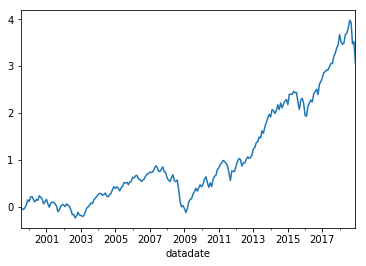

In [5]:
epd.nav(monthly_return).plot()

In [6]:
monthly_return.resample('A').apply(epd.prod_red)

datadate
1999-12-31    0.143674
2000-12-31   -0.035320
2001-12-31   -0.051999
2002-12-31   -0.212842
2003-12-31    0.473910
2004-12-31    0.174388
2005-12-31    0.077602
2006-12-31    0.108890
2007-12-31    0.013636
2008-12-31   -0.407166
2009-12-31    0.431074
2010-12-31    0.223220
2011-12-31   -0.019961
2012-12-31    0.193899
2013-12-31    0.416925
2014-12-31    0.106292
2015-12-31   -0.024153
2016-12-31    0.143792
2017-12-31    0.214276
2018-12-31   -0.087639
Freq: A-DEC, Name: port_return, dtype: float64

## Fetch Factor Models

In [7]:
# Get Factor Models
q_factor_model = bi.get_q_factor_model()
fama_french_five_factor_model = bi.get_fama_french_five_factor_model()
four_factor_model = bi.get_four_factor_model()

# Concat Portfolio Return
q_factor = pd.concat([monthly_return, q_factor_model], axis=1)
fama_french_five = pd.concat([monthly_return, fama_french_five_factor_model], axis=1)
four_factor = pd.concat([monthly_return, four_factor_model], axis=1)

# Add Constants
q_factor.insert(1, 'const', 1)
fama_french_five.insert(1, 'const', 1)
four_factor.insert(1, 'const', 1)

# Split Period into Pre and Post Crisis
q_factor_pre, q_factor_post = q_factor.loc[:'2009-06-30'], q_factor.loc['2009-07-31':]
fama_french_five_pre, fama_french_five_post = fama_french_five.loc[:'2009-06-30'], fama_french_five.loc['2009-07-31':] 
four_factor_pre, four_factor_post = four_factor.loc[:'2009-06-30'], four_factor.loc['2009-07-31':] 

## Full Time Period Regressions

### Q Factor Model

In [8]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     2926.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.90e-195
Time:                        13:36:08   Log-Likelihood:                 835.71
No. Observations:                 234   AIC:                            -1661.
Df Residuals:                     229   BIC:                            -1644.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.000      4.692      0.000       0.001       0.003
mktrf          1.0155      0.013     79.176      0.000       0.990       1.041
me             0.2812      0.015     18.850      0.000       0.252       0.311
ia             0.0494      0.023      2.179      0.030       0.005       0.094
roe           -0.0618      0.019     -3.185      0.002      -0.100      -0.024
==============================================================================
Omnibus:                       26.056   Durbin-Watson:                   1.886
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              126.094
Skew:                          -0.119   Prob(JB):                     4.16e-28
Kurtosis:                       6.588   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [9]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     1693.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          9.74e-169
Time:                        13:36:08   Log-Likelihood:                 835.71
No. Observations:                 234   AIC:                            -1661.
Df Residuals:                     229   BIC:                            -1644.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.000      4.688      0.000       0.001       0.003
mktrf          1.0155      0.016     64.386      0.000       0.985       1.046
me             0.2812      0.023     12.410      0.000       0.237       0.326
ia             0.0494      0.045      1.101      0.271      -0.039       0.137
roe           -0.0618      0.029     -2.134      0.033      -0.119      -0.005
==============================================================================
Omnibus:                       26.056   Durbin-Watson:                   1.886
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              126.094
Skew:                          -0.119   Prob(JB):                     4.16e-28
Kurtosis:                       6.588   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [10]:
sm.OLS(q_factor.iloc[:, :1], q_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.981
Model:                            OLS   Adj. R-squared:                  0.980
Method:                 Least Squares   F-statistic:                     2038.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.10e-177
Time:                        13:36:08   Log-Likelihood:                 835.71
No. Observations:                 234   AIC:                            -1661.
Df Residuals:                     229   BIC:                            -1644.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0022      0.000      4.982      0.000       0.001       0.003
mktrf          1.0155      0.015     65.812      0.000       0.985       1.046
me             0.2812      0.022     13.037      0.000       0.239       0.324
ia             0.0494      0.046      1.085      0.278      -0.040       0.139
roe           -0.0618      0.032     -1.902      0.057      -0.126       0.002
==============================================================================
Omnibus:                       26.056   Durbin-Watson:                   1.886
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              126.094
Skew:                          -0.119   Prob(JB):                     4.16e-28
Kurtosis:                       6.588   Cond. No.                         53.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [11]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     1979.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.40e-185
Time:                        13:36:08   Log-Likelihood:                 816.98
No. Observations:                 234   AIC:                            -1622.
Df Residuals:                     228   BIC:                            -1601.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      3.714      0.000       0.001       0.003
mktrf          1.0320      0.014     73.964      0.000       1.005       1.060
smb            0.3076      0.018     16.707      0.000       0.271       0.344
hml            0.0170      0.022      0.781      0.436      -0.026       0.060
rmw           -0.0375      0.025     -1.527      0.128      -0.086       0.011
cma            0.0500      0.031      1.603      0.110      -0.011       0.111
==============================================================================
Omnibus:                       27.025   Durbin-Watson:                   1.726
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              143.095
Skew:                           0.038   Prob(JB):                     8.46e-32
Kurtosis:                       6.830   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [12]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     1644.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.31e-176
Time:                        13:36:08   Log-Likelihood:                 816.98
No. Observations:                 234   AIC:                            -1622.
Df Residuals:                     228   BIC:                            -1601.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      3.517      0.000       0.001       0.003
mktrf          1.0320      0.017     60.427      0.000       0.999       1.065
smb            0.3076      0.023     13.170      0.000       0.262       0.353
hml            0.0170      0.048      0.351      0.726      -0.078       0.112
rmw           -0.0375      0.031     -1.219      0.223      -0.098       0.023
cma            0.0500      0.050      1.008      0.314      -0.047       0.147
==============================================================================
Omnibus:                       27.025   Durbin-Watson:                   1.726
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              143.095
Skew:                           0.038   Prob(JB):                     8.46e-32
Kurtosis:                       6.830   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [13]:
sm.OLS(fama_french_five.iloc[:, :1], fama_french_five.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.977
Model:                            OLS   Adj. R-squared:                  0.977
Method:                 Least Squares   F-statistic:                     2185.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.33e-190
Time:                        13:36:08   Log-Likelihood:                 816.98
No. Observations:                 234   AIC:                            -1622.
Df Residuals:                     228   BIC:                            -1601.
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0019      0.001      3.495      0.000       0.001       0.003
mktrf          1.0320      0.017     62.237      0.000       1.000       1.065
smb            0.3076      0.023     13.385      0.000       0.263       0.353
hml            0.0170      0.050      0.337      0.736      -0.082       0.115
rmw           -0.0375      0.034     -1.107      0.268      -0.104       0.029
cma            0.0500      0.048      1.049      0.294      -0.043       0.143
==============================================================================
Omnibus:                       27.025   Durbin-Watson:                   1.726
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              143.095
Skew:                           0.038   Prob(JB):                     8.46e-32
Kurtosis:                       6.830   Cond. No.                         72.5
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [14]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                     2232.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          4.37e-182
Time:                        13:36:08   Log-Likelihood:                 804.70
No. Observations:                 234   AIC:                            -1599.
Df Residuals:                     229   BIC:                            -1582.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      3.846      0.000       0.001       0.003
mktrf          1.0282      0.013     76.261      0.000       1.002       1.055
smb            0.3091      0.017     18.367      0.000       0.276       0.342
hml            0.0812      0.017      4.857      0.000       0.048       0.114
umd           -0.0193      0.011     -1.763      0.079      -0.041       0.002
==============================================================================
Omnibus:                       26.429   Durbin-Watson:                   1.789
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              134.513
Skew:                           0.067   Prob(JB):                     6.18e-30
Kurtosis:                       6.712   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [15]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                     1893.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          4.01e-174
Time:                        13:36:09   Log-Likelihood:                 804.70
No. Observations:                 234   AIC:                            -1599.
Df Residuals:                     229   BIC:                            -1582.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      3.230      0.001       0.001       0.003
mktrf          1.0282      0.018     57.318      0.000       0.993       1.063
smb            0.3091      0.023     13.313      0.000       0.264       0.355
hml            0.0812      0.048      1.697      0.090      -0.013       0.175
umd           -0.0193      0.020     -0.951      0.342      -0.059       0.021
==============================================================================
Omnibus:                       26.429   Durbin-Watson:                   1.789
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              134.513
Skew:                           0.067   Prob(JB):                     6.18e-30
Kurtosis:                       6.712   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [16]:
sm.OLS(four_factor.iloc[:, :1], four_factor.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.975
Model:                            OLS   Adj. R-squared:                  0.975
Method:                 Least Squares   F-statistic:                     2344.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.82e-184
Time:                        13:36:09   Log-Likelihood:                 804.70
No. Observations:                 234   AIC:                            -1599.
Df Residuals:                     229   BIC:                            -1582.
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0020      0.001      3.193      0.001       0.001       0.003
mktrf          1.0282      0.015     67.190      0.000       0.998       1.058
smb            0.3091      0.024     12.790      0.000       0.262       0.356
hml            0.0812      0.053      1.544      0.122      -0.022       0.184
umd           -0.0193      0.017     -1.165      0.244      -0.052       0.013
==============================================================================
Omnibus:                       26.429   Durbin-Watson:                   1.789
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              134.513
Skew:                           0.067   Prob(JB):                     6.18e-30
Kurtosis:                       6.712   Cond. No.                         36.8
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Pre-Crisis Regressions

### Q Factor Model

In [17]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     1294.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.42e-94
Time:                        13:36:09   Log-Likelihood:                 408.62
No. Observations:                 120   AIC:                            -807.2
Df Residuals:                     115   BIC:                            -793.3
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0028      0.001      3.619      0.000       0.001       0.004
mktrf          1.0219      0.021     48.314      0.000       0.980       1.064
me             0.2637      0.021     12.621      0.000       0.222       0.305
ia             0.0854      0.033      2.610      0.010       0.021       0.150
roe           -0.0596      0.029     -2.060      0.042      -0.117      -0.002
==============================================================================
Omnibus:                       10.265   Durbin-Watson:                   1.920
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               24.490
Skew:                          -0.118   Prob(JB):                     4.81e-06
Kurtosis:                       5.201   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [18]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     922.0
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.43e-86
Time:                        13:36:09   Log-Likelihood:                 408.62
No. Observations:                 120   AIC:                            -807.2
Df Residuals:                     115   BIC:                            -793.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0028      0.001      3.613      0.000       0.001       0.004
mktrf          1.0219      0.027     38.010      0.000       0.969       1.075
me             0.2637      0.024     10.930      0.000       0.216       0.311
ia             0.0854      0.051      1.682      0.093      -0.014       0.185
roe           -0.0596      0.036     -1.672      0.095      -0.130       0.010
==============================================================================
Omnibus:                       10.265   Durbin-Watson:                   1.920
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               24.490
Skew:                          -0.118   Prob(JB):                     4.81e-06
Kurtosis:                       5.201   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [19]:
sm.OLS(q_factor_pre.iloc[:, :1], q_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.978
Model:                            OLS   Adj. R-squared:                  0.978
Method:                 Least Squares   F-statistic:                     1477.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           8.15e-98
Time:                        13:36:09   Log-Likelihood:                 408.62
No. Observations:                 120   AIC:                            -807.2
Df Residuals:                     115   BIC:                            -793.3
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0028      0.001      3.703      0.000       0.001       0.004
mktrf          1.0219      0.024     42.749      0.000       0.975       1.069
me             0.2637      0.024     11.204      0.000       0.218       0.310
ia             0.0854      0.045      1.887      0.059      -0.003       0.174
roe           -0.0596      0.038     -1.563      0.118      -0.134       0.015
==============================================================================
Omnibus:                       10.265   Durbin-Watson:                   1.920
Prob(Omnibus):                  0.006   Jarque-Bera (JB):               24.490
Skew:                          -0.118   Prob(JB):                     4.81e-06
Kurtosis:                       5.201   Cond. No.                         47.0
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [20]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     855.4
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.33e-88
Time:                        13:36:09   Log-Likelihood:                 397.98
No. Observations:                 120   AIC:                            -784.0
Df Residuals:                     114   BIC:                            -767.2
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0031      0.001      3.462      0.001       0.001       0.005
mktrf          1.0710      0.024     43.751      0.000       1.023       1.119
smb            0.3069      0.028     11.067      0.000       0.252       0.362
hml           -0.0107      0.034     -0.315      0.754      -0.078       0.057
rmw           -0.0002      0.040     -0.005      0.996      -0.080       0.079
cma            0.1161      0.044      2.645      0.009       0.029       0.203
==============================================================================
Omnibus:                       12.823   Durbin-Watson:                   1.846
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               36.582
Skew:                          -0.174   Prob(JB):                     1.14e-08
Kurtosis:                       5.682   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [21]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     1044.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           2.07e-93
Time:                        13:36:09   Log-Likelihood:                 397.98
No. Observations:                 120   AIC:                            -784.0
Df Residuals:                     114   BIC:                            -767.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0031      0.001      3.443      0.001       0.001       0.005
mktrf          1.0710      0.032     32.971      0.000       1.007       1.135
smb            0.3069      0.036      8.530      0.000       0.236       0.377
hml           -0.0107      0.079     -0.136      0.892      -0.165       0.144
rmw           -0.0002      0.060     -0.003      0.997      -0.119       0.118
cma            0.1161      0.060      1.945      0.052      -0.001       0.233
==============================================================================
Omnibus:                       12.823   Durbin-Watson:                   1.846
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               36.582
Skew:                          -0.174   Prob(JB):                     1.14e-08
Kurtosis:                       5.682   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [22]:
sm.OLS(fama_french_five_pre.iloc[:, :1], fama_french_five_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.974
Model:                            OLS   Adj. R-squared:                  0.973
Method:                 Least Squares   F-statistic:                     1834.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          3.98e-107
Time:                        13:36:09   Log-Likelihood:                 397.98
No. Observations:                 120   AIC:                            -784.0
Df Residuals:                     114   BIC:                            -767.2
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0031      0.001      3.602      0.000       0.001       0.005
mktrf          1.0710      0.031     34.668      0.000       1.010       1.132
smb            0.3069      0.036      8.497      0.000       0.236       0.378
hml           -0.0107      0.084     -0.127      0.899      -0.175       0.154
rmw           -0.0002      0.066     -0.003      0.997      -0.130       0.130
cma            0.1161      0.057      2.039      0.041       0.004       0.228
==============================================================================
Omnibus:                       12.823   Durbin-Watson:                   1.846
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               36.582
Skew:                          -0.174   Prob(JB):                     1.14e-08
Kurtosis:                       5.682   Cond. No.                         67.9
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [23]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                     927.9
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           1.70e-86
Time:                        13:36:09   Log-Likelihood:                 389.20
No. Observations:                 120   AIC:                            -768.4
Df Residuals:                     115   BIC:                            -754.5
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0034      0.001      3.817      0.000       0.002       0.005
mktrf          1.0433      0.022     47.622      0.000       1.000       1.087
smb            0.3007      0.025     12.056      0.000       0.251       0.350
hml            0.0993      0.025      3.976      0.000       0.050       0.149
umd           -0.0153      0.015     -0.992      0.323      -0.046       0.015
==============================================================================
Omnibus:                       12.327   Durbin-Watson:                   1.880
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               35.770
Skew:                          -0.104   Prob(JB):                     1.71e-08
Kurtosis:                       5.667   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [24]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                     1163.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):           5.66e-92
Time:                        13:36:09   Log-Likelihood:                 389.20
No. Observations:                 120   AIC:                            -768.4
Df Residuals:                     115   BIC:                            -754.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0034      0.001      3.954      0.000       0.002       0.005
mktrf          1.0433      0.029     36.076      0.000       0.987       1.100
smb            0.3007      0.029     10.526      0.000       0.245       0.357
hml            0.0993      0.061      1.624      0.104      -0.021       0.219
umd           -0.0153      0.024     -0.630      0.529      -0.063       0.032
==============================================================================
Omnibus:                       12.327   Durbin-Watson:                   1.880
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               35.770
Skew:                          -0.104   Prob(JB):                     1.71e-08
Kurtosis:                       5.667   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [25]:
sm.OLS(four_factor_pre.iloc[:, :1], four_factor_pre.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.970
Model:                            OLS   Adj. R-squared:                  0.969
Method:                 Least Squares   F-statistic:                     1704.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          2.58e-101
Time:                        13:36:09   Log-Likelihood:                 389.20
No. Observations:                 120   AIC:                            -768.4
Df Residuals:                     115   BIC:                            -754.5
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0034      0.001      4.191      0.000       0.002       0.005
mktrf          1.0433      0.022     46.720      0.000       1.000       1.087
smb            0.3007      0.030     10.043      0.000       0.242       0.359
hml            0.0993      0.066      1.506      0.132      -0.030       0.229
umd           -0.0153      0.019     -0.811      0.417      -0.052       0.022
==============================================================================
Omnibus:                       12.327   Durbin-Watson:                   1.880
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               35.770
Skew:                          -0.104   Prob(JB):                     1.71e-08
Kurtosis:                       5.667   Cond. No.                         33.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

## Post-Crisis Regressions

### Q Factor Model

In [26]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     2460.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          7.92e-106
Time:                        13:36:09   Log-Likelihood:                 456.28
No. Observations:                 114   AIC:                            -902.6
Df Residuals:                     109   BIC:                            -888.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.000      3.834      0.000       0.001       0.003
mktrf          1.0096      0.013     75.954      0.000       0.983       1.036
me             0.3198      0.021     15.584      0.000       0.279       0.360
ia            -0.0760      0.028     -2.668      0.009      -0.132      -0.020
roe           -0.1157      0.025     -4.624      0.000      -0.165      -0.066
==============================================================================
Omnibus:                        8.742   Durbin-Watson:                   2.080
Prob(Omnibus):                  0.013   Jarque-Bera (JB):                8.489
Skew:                          -0.623   Prob(JB):                       0.0143
Kurtosis:                       3.482   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Q Factor Model - Newey West (9 Lag)

In [27]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     4107.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          7.48e-118
Time:                        13:36:09   Log-Likelihood:                 456.28
No. Observations:                 114   AIC:                            -902.6
Df Residuals:                     109   BIC:                            -888.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.000      4.126      0.000       0.001       0.003
mktrf          1.0096      0.010    100.870      0.000       0.990       1.029
me             0.3198      0.016     19.679      0.000       0.288       0.352
ia            -0.0760      0.029     -2.579      0.010      -0.134      -0.018
roe           -0.1157      0.024     -4.816      0.000      -0.163      -0.069
==============================================================================
Omnibus:                        8.742   Durbin-Watson:                   2.080
Prob(Omnibus):                  0.013   Jarque-Bera (JB):                8.489
Skew:                          -0.623   Prob(JB):                       0.0143
Kurtosis:                       3.482   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Q Factor Model - Newey West (18 Lag)

In [28]:
sm.OLS(q_factor_post.iloc[:, :1], q_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.989
Model:                            OLS   Adj. R-squared:                  0.989
Method:                 Least Squares   F-statistic:                     4870.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          7.34e-122
Time:                        13:36:09   Log-Likelihood:                 456.28
No. Observations:                 114   AIC:                            -902.6
Df Residuals:                     109   BIC:                            -888.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0017      0.000      4.049      0.000       0.001       0.003
mktrf          1.0096      0.009    106.618      0.000       0.991       1.028
me             0.3198      0.016     20.288      0.000       0.289       0.351
ia            -0.0760      0.032     -2.377      0.017      -0.139      -0.013
roe           -0.1157      0.022     -5.165      0.000      -0.160      -0.072
==============================================================================
Omnibus:                        8.742   Durbin-Watson:                   2.080
Prob(Omnibus):                  0.013   Jarque-Bera (JB):                8.489
Skew:                          -0.623   Prob(JB):                       0.0143
Kurtosis:                       3.482   Cond. No.                         67.7
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Fama French Five Factor Model

In [29]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                     2620.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          5.80e-111
Time:                        13:36:09   Log-Likelihood:                 472.96
No. Observations:                 114   AIC:                            -933.9
Df Residuals:                     108   BIC:                            -917.5
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.000      2.145      0.034    6.39e-05       0.002
mktrf          1.0160      0.011     92.346      0.000       0.994       1.038
smb            0.2944      0.018     16.484      0.000       0.259       0.330
hml            0.0136      0.023      0.597      0.552      -0.032       0.059
rmw           -0.1760      0.028     -6.309      0.000      -0.231      -0.121
cma           -0.1002      0.035     -2.830      0.006      -0.170      -0.030
==============================================================================
Omnibus:                        9.745   Durbin-Watson:                   2.040
Prob(Omnibus):                  0.008   Jarque-Bera (JB):                9.676
Skew:                          -0.654   Prob(JB):                      0.00792
Kurtosis:                       3.570   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Fama French Five Factor Model - Newey West (9 Lag)

In [30]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                     3080.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.00e-114
Time:                        13:36:09   Log-Likelihood:                 472.96
No. Observations:                 114   AIC:                            -933.9
Df Residuals:                     108   BIC:                            -917.5
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.000      2.123      0.034    6.45e-05       0.002
mktrf          1.0160      0.009    110.475      0.000       0.998       1.034
smb            0.2944      0.016     18.758      0.000       0.264       0.325
hml            0.0136      0.019      0.717      0.473      -0.024       0.051
rmw           -0.1760      0.024     -7.290      0.000      -0.223      -0.129
cma           -0.1002      0.038     -2.604      0.009      -0.176      -0.025
==============================================================================
Omnibus:                        9.745   Durbin-Watson:                   2.040
Prob(Omnibus):                  0.008   Jarque-Bera (JB):                9.676
Skew:                          -0.654   Prob(JB):                      0.00792
Kurtosis:                       3.570   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Fama French Five Factor Model - Newey West (18 Lag)

In [31]:
sm.OLS(fama_french_five_post.iloc[:, :1], fama_french_five_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.992
Model:                            OLS   Adj. R-squared:                  0.991
Method:                 Least Squares   F-statistic:                     4754.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          7.58e-125
Time:                        13:36:09   Log-Likelihood:                 472.96
No. Observations:                 114   AIC:                            -933.9
Df Residuals:                     108   BIC:                            -917.5
Df Model:                           5                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0008      0.000      1.945      0.052   -6.44e-06       0.002
mktrf          1.0160      0.008    128.613      0.000       1.001       1.032
smb            0.2944      0.014     20.600      0.000       0.266       0.322
hml            0.0136      0.018      0.739      0.460      -0.022       0.050
rmw           -0.1760      0.025     -7.024      0.000      -0.225      -0.127
cma           -0.1002      0.039     -2.568      0.010      -0.177      -0.024
==============================================================================
Omnibus:                        9.745   Durbin-Watson:                   2.040
Prob(Omnibus):                  0.008   Jarque-Bera (JB):                9.676
Skew:                          -0.654   Prob(JB):                      0.00792
Kurtosis:                       3.570   Cond. No.                         109.
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""

### Carhart Four Factor Model

In [32]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                     2231.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.54e-103
Time:                        13:36:09   Log-Likelihood:                 450.77
No. Observations:                 114   AIC:                            -891.5
Df Residuals:                     109   BIC:                            -877.9
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.000      0.970      0.334      -0.000       0.001
mktrf          1.0286      0.013     77.807      0.000       1.002       1.055
smb            0.3352      0.021     16.259      0.000       0.294       0.376
hml            0.0033      0.021      0.158      0.875      -0.039       0.045
umd           -0.0358      0.016     -2.238      0.027      -0.068      -0.004
==============================================================================
Omnibus:                        4.638   Durbin-Watson:                   1.756
Prob(Omnibus):                  0.098   Jarque-Bera (JB):                4.019
Skew:                          -0.406   Prob(JB):                        0.134
Kurtosis:                       3.434   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Carhart Four Factor Model - Newey West (9 Lag)

In [33]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':9}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                     2047.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.59e-101
Time:                        13:36:09   Log-Likelihood:                 450.77
No. Observations:                 114   AIC:                            -891.5
Df Residuals:                     109   BIC:                            -877.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.000      0.952      0.341      -0.000       0.001
mktrf          1.0286      0.013     77.419      0.000       1.003       1.055
smb            0.3352      0.018     18.437      0.000       0.300       0.371
hml            0.0033      0.019      0.173      0.863      -0.035       0.041
umd           -0.0358      0.012     -2.907      0.004      -0.060      -0.012
==============================================================================
Omnibus:                        4.638   Durbin-Watson:                   1.756
Prob(Omnibus):                  0.098   Jarque-Bera (JB):                4.019
Skew:                          -0.406   Prob(JB):                        0.134
Kurtosis:                       3.434   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 9 lags and without small sample correction
"""

### Carhart Four Factor Model - Newey West (18 Lag)

In [34]:
sm.OLS(four_factor_post.iloc[:, :1], four_factor_post.iloc[:, 1:]).fit(
    cov_type='HAC', cov_kwds={'maxlags':18}).summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            port_return   R-squared:                       0.988
Model:                            OLS   Adj. R-squared:                  0.987
Method:                 Least Squares   F-statistic:                     4061.
Date:                Mon, 27 Apr 2020   Prob (F-statistic):          1.38e-117
Time:                        13:36:09   Log-Likelihood:                 450.77
No. Observations:                 114   AIC:                            -891.5
Df Residuals:                     109   BIC:                            -877.9
Df Model:                           4                                         
Covariance Type:                  HAC                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0005      0.000      0.948      0.343      -0.000       0.001
mktrf          1.0286      0.012     82.916      0.000       1.004       1.053
smb            0.3352      0.014     24.752      0.000       0.309       0.362
hml            0.0033      0.017      0.199      0.842      -0.030       0.036
umd           -0.0358      0.012     -3.027      0.002      -0.059      -0.013
==============================================================================
Omnibus:                        4.638   Durbin-Watson:                   1.756
Prob(Omnibus):                  0.098   Jarque-Bera (JB):                4.019
Skew:                          -0.406   Prob(JB):                        0.134
Kurtosis:                       3.434   Cond. No.                         52.2
==============================================================================

Warnings:
[1] Standard Errors are heteroscedasticity and autocorrelation robust (HAC) using 18 lags and without small sample correction
"""